In [14]:
import numpy as np
import scipy
import pandas as pd
import seaborn as sns
import seaborn.objects as so

from sklearn import linear_model    # Herramientas de modelos lineales
from sklearn.preprocessing import PolynomialFeatures    # Herramientas de polinomios
from sklearn.metrics import mean_squared_error, r2_score    # Medidas de desempeño
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from formulaic import Formula

# Resumen Laboratorio de Datos

# Modelo de Regresion Lineal

In [15]:
# Completar regr lineal

## Modelo de Cuadrados Minimos

Queremos buscar el polinomio de grado 3 que mejor aproxima a los datos en sentido de cuadrados mínimos:
$$P(x) = \beta_0 + \beta_1 x + \beta_2 x^ 2 + \beta_3 x^ 3$$

In [2]:
from gapminder import gapminder
datos_arg = gapminder[gapminder['country'] == 'Argentina']
datos_arg.head()

,country,continent,year,lifeExp,pop,gdpPercap
48,Argentina,Americas,1952,62.485,17876956,5911.315053
49,Argentina,Americas,1957,64.399,19610538,6856.856212
50,Argentina,Americas,1962,65.142,21283783,7133.166023
51,Argentina,Americas,1967,65.634,22934225,8052.953021
52,Argentina,Americas,1972,67.065,24779799,9443.038526


In [3]:
X_train, X_test, y_train, y_test = train_test_split(datos_arg["year"], datos_arg["gdpPercap"], test_size = 0.2, random_state = 42)

In [4]:
X_train

56    1992
53    1977
50    1962
49    1957
59    2007
52    1972
55    1987
51    1967
54    1982
Name: year, dtype: int64

In [5]:
# Indicamos que queremos un polinomio de grado 3 sin ordenada al origen B_0 (bias)
polynomial_features = PolynomialFeatures(degree = 3, include_bias=False)

# Armo matrices cuyas columnas son x, x², x³.
x_train_poly = polynomial_features.fit_transform(X_train.values.reshape(-1, 1))
x_test_poly = polynomial_features.transform(X_test.values.reshape(-1, 1))

# Como separamos X en train y test, hay que armas las 2

In [6]:
# Ahora inicializamos el modelo de regresion lineal como siempre
modelo = linear_model.LinearRegression()

# Realizo el ajuste
modelo.fit(x_train_poly, y_train)

# Recuperamos los valores de los coeficientes (de menor potencia a mayor)
beta = modelo.coef_

# Recuperamos la ordenada al origen
o_origen = modelo.intercept_.item()

# Imprimimos los valores:
print('beta_0: ', o_origen)
print('beta_1: ', beta[0])
print('beta_2: ', beta[1])
print('beta_3: ', beta[2])

beta_0:  -1520357273.9732614
beta_1:  2302199.692258943
beta_2:  -1162.0295845868204
beta_3:  0.19551085508123833


El polinomio de grado a lo sumo 3 que mejor aproxima a los datos es:
$$P(x) = -1520357273.9 + 2302199.69 x -1162 x^ 2 + 0.1955 x^ 3 $$

Corroboremos que el gráfico de este polinomio es el mismo que arma `seaborn` con `so.PolyFit`:

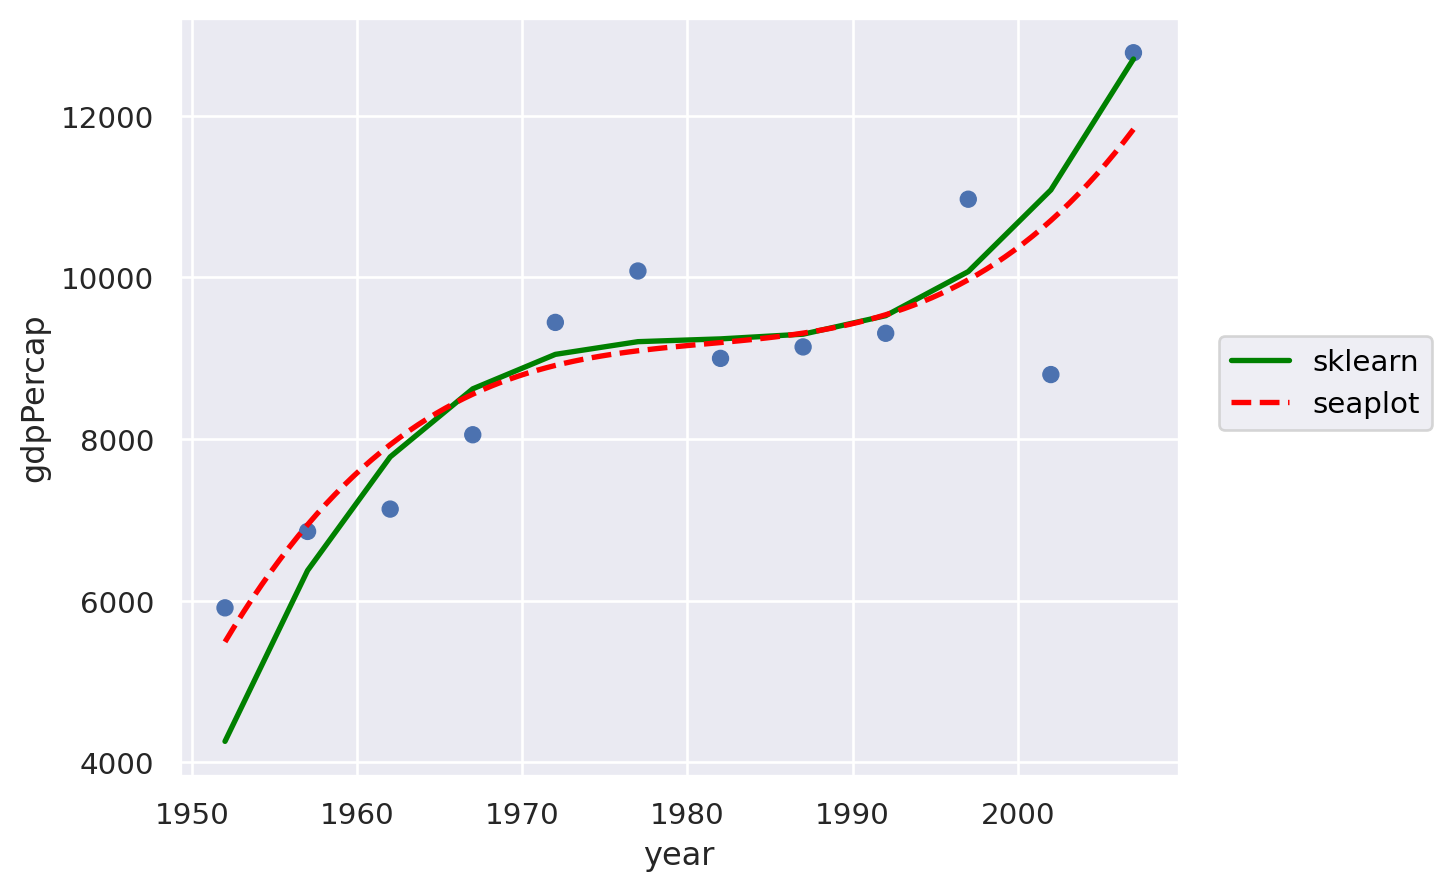

In [7]:
(
    so.Plot(data=datos_arg, x='year', y='gdpPercap')
    .add(so.Dot())
    .add(so.Line(color='green', linewidth=2), y=o_origen + beta[0]*datos_arg['year'] + beta[1]*datos_arg['year']**2 + beta[2]*datos_arg['year']**3, label='sklearn')
    .add(so.Line(color='red', linestyle='--', linewidth=2), so.PolyFit(3), label='seaplot')
    .label()
)

In [8]:
# Hacemos las predicciones
y_pred = modelo.predict(x_test_poly)

# Evaluamos el desempeño del modelo con sqrt(ECM)
sq_ecm = np.sqrt(mean_squared_error(y_test, y_pred))

# Obtenemos el R² del modelo
r2 = r2_score(y_test, y_pred)

display(sq_ecm, r2)


1707.6233471171647

0.32012684282160386

## Modelo Lineal Multivariado (MLM)

**FORMULAIC**


| Operador | Ejemplo          | Función                                                                                           |
|:---------|:-----------------|:---------------------------------------------------------------------------------------------------|
| ~        | y ~ x            | Separa la variable (y) respuesta a la izquierda, de el/los predictor/es a la derecha (x).       |
| +        | y ~ x + z        | Adiciona (suma) términos al modelo.                                                              |
| :        | y ~ x : z        | Interacción entre términos. y es lineal en x ⋅ z.                                                |
| *        | y ~ x * z        | Combina adición e interacción entre términos. y ~ x * z es equivalente a y ~ x + z + x : z       |

Hemos visto modelos univariados (Regresion Lineal):
$$y = \beta_0 + \beta_1 x$$

Y polinomios en una variable (Cuadrados Minimos):
$$y = \beta_0 + \beta_1 x + \beta_2 x^ 2 + \beta_3 x^ 3$$

Estos 2 modelos son Lineales, es decir que usan sólo una variable dependiente.

---

En MLM vamos a estar utilizando muchas variables dependientes (Con Formulaic) a la vez.

Ejemplo: Estudiar la relacio entre la **masa corporal** de los Pinguinos, su **sexo**, su **isla** y el **largo de las aletas**:

- y ~ **masa corporal** + **sexo** + **isla** + **largo de las aletas** 

(Recordar que las variables categóricas (como isla, sexo, etc) van a ser decodificadas usando OHE (One Hot Encoder))

---

Veamos como usar MLM para estudiar la relacion entre la longitus y la profundidad del pico de los pinguinos

In [16]:
penguins = sns.load_dataset("penguins")  
penguins = penguins.dropna()            # Eliminamos las filas con datos faltantes
penguins.head(2)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female


In [17]:
# Ajustamos un modelo lineal y calculamos el coeficiente de correlación R^2
y, X = (
    Formula('bill_depth_mm ~ bill_length_mm')
    .get_model_matrix(penguins)
)
display(X.head()) 

,Intercept,bill_length_mm
0,1.0,39.1
1,1.0,39.5
2,1.0,40.3
4,1.0,36.7
5,1.0,39.3


In [18]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realizamos el ajuste
print("Coeficientes:", modelo.coef_)

y_pred = modelo.predict(X)
# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

# Calculando el ECM
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadarada del ECM: ', np.sqrt(ecm))

Coeficientes: [[20.78664867 -0.08232675]]
R^2:  0.0522696813966369
Raiz cuadarada del ECM:  1.914198451038257


Si analizamos rápidamente estos resultados diríamos que no hay relación entre el largo y la produndidad... (o que hay correlación negativa porque la pendiente es negativa). Resulta un poco extraño...

Realicemos un Grafico

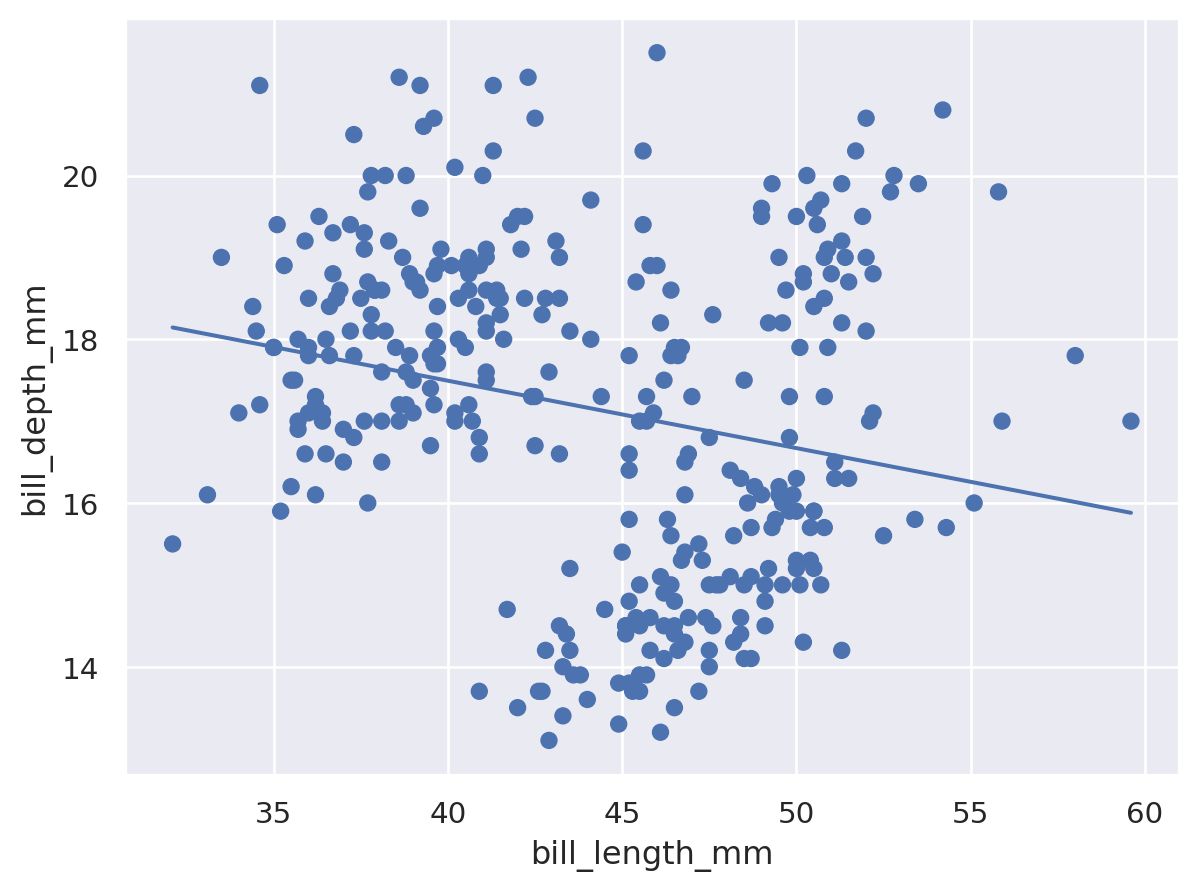

In [19]:
(
    so.Plot(data = penguins, x = "bill_length_mm", y = "bill_depth_mm")
    .add(so.Dot())
    .add(so.Line(), so.PolyFit(1))
)

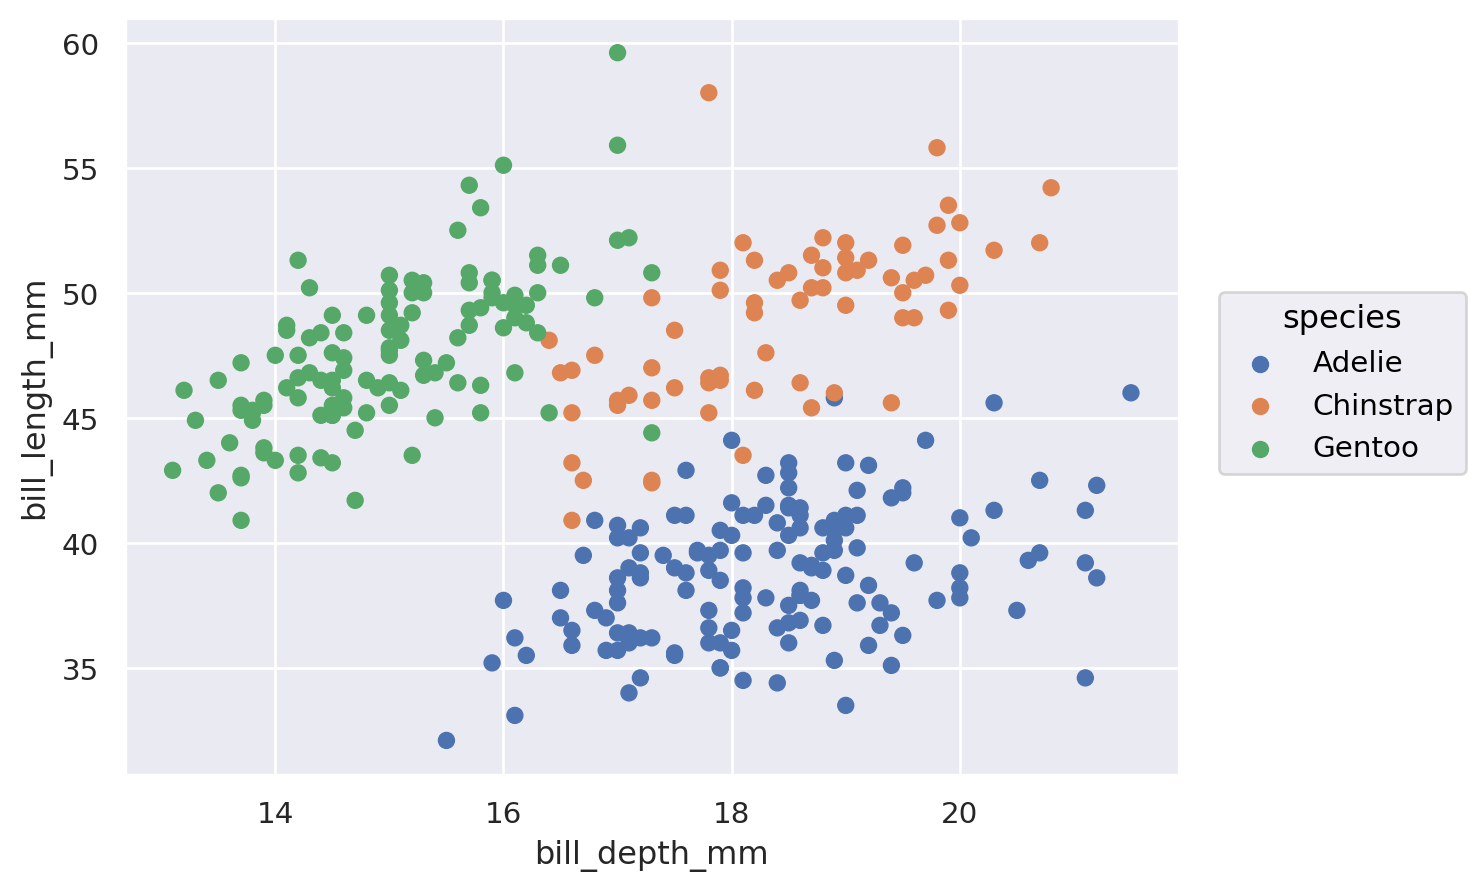

In [25]:
# Capaz no predice bien nuestra regresion lineal porque tiene que ver con las especies?
(
    so.Plot(data = penguins, x = "bill_depth_mm", y = "bill_length_mm", color = "species")
    .add(so.Dot())
)

Ahora las rectas tienen pendiente positiva! Al considerar todas las especies al mismo tiempo, no podíamos ver esta correlación.

---

¿Cómo podemos construir nosotros estos modelos y calcular los coeficientes y el R^2?

Recordemos las operaciones que nos permite hacer Formulaic.

| Operador | Ejemplo          | Función                                                                                           |
|:---------|:-----------------|:---------------------------------------------------------------------------------------------------|
| ~        | y ~ x            | Separa la variable (y) respuesta a la izquierda, de el/los predictor/es a la derecha (x).       |
| +        | y ~ x + z        | Adiciona (suma) términos al modelo.                                                              |
| :        | y ~ x : z        | Interacción entre términos. y es lineal en x ⋅ z.                                                |
| *        | y ~ x * z        | Combina adición e interacción entre términos. y ~ x * z es equivalente a y ~ x + z + x : z       |

Capaz si metemos la nueva variable "species" dentro de nuestra ecuacion la cosa cambia.

In [23]:
# Ajustamos un modelo lineal y calculamos el coeficiente de correlación R^2
y, X = (
    Formula('bill_depth_mm ~ (1 + bill_length_mm) : species - 1')
    .get_model_matrix(penguins)
)
display(X.tail()) 

,species[T.Adelie],species[T.Chinstrap],species[T.Gentoo],bill_length_mm:species[T.Adelie],bill_length_mm:species[T.Chinstrap],bill_length_mm:species[T.Gentoo]
338,0,0,1,0.0,0.0,47.2
340,0,0,1,0.0,0.0,46.8
341,0,0,1,0.0,0.0,50.4
342,0,0,1,0.0,0.0,45.2
343,0,0,1,0.0,0.0,49.9


Ahora, con nuestros nuevos datos, generemos un nuevo modelo de Regresion Lineal

Coeficientes: [[11.48770713  7.56914012  5.12095595  0.17668344  0.22221172  0.2076116 ]]


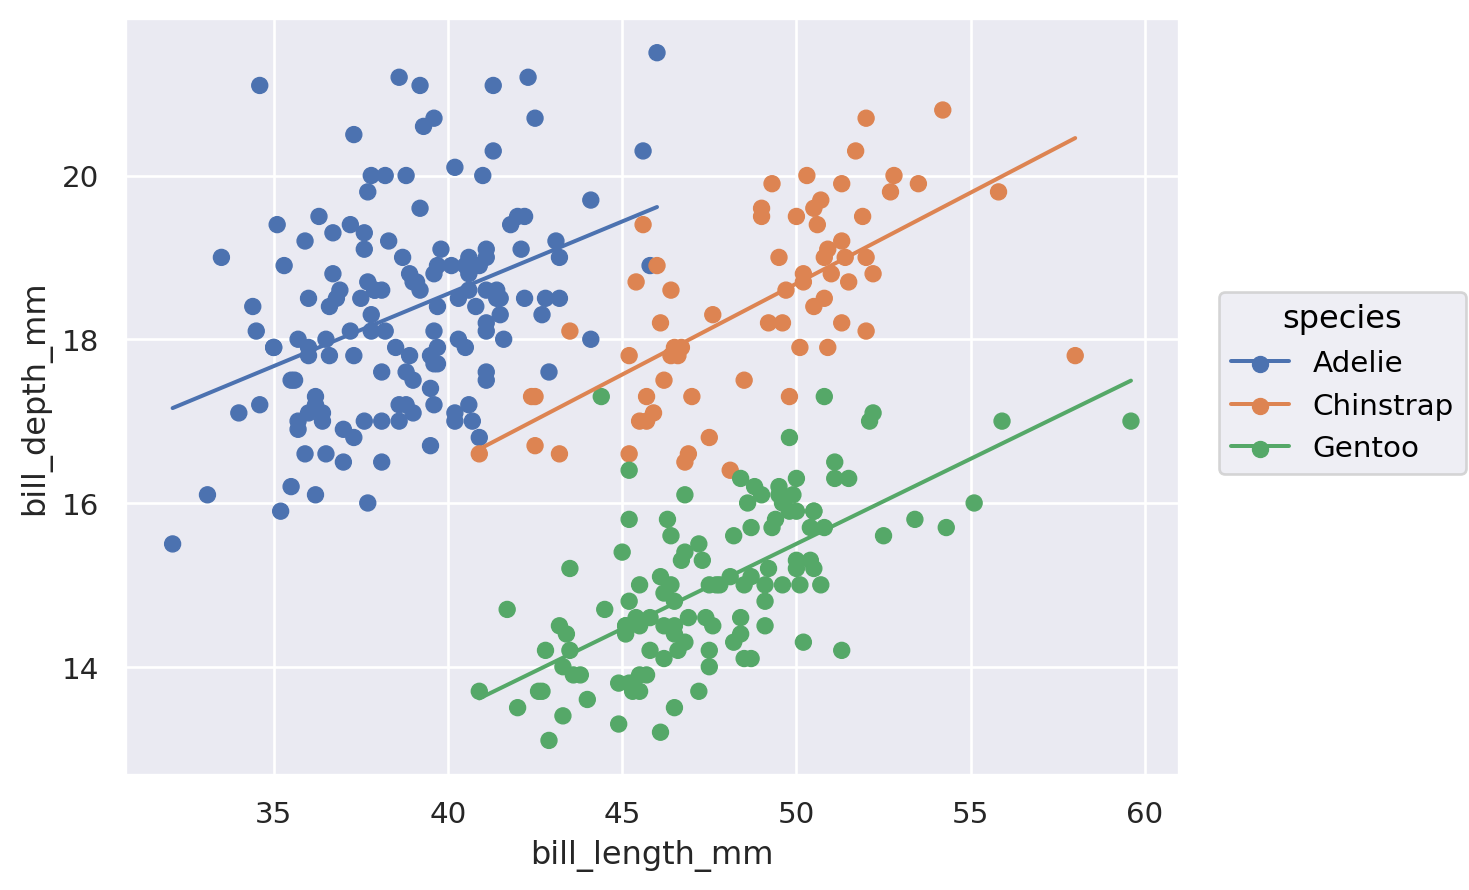

In [24]:
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal
modelo.fit(X, y)   # Realiza

print("Coeficientes:", modelo.coef_)

y_pred = modelo.predict(X)

(
    so.Plot(data = penguins, x = "bill_length_mm")
    .add(so.Dot(), color = "species", y = "bill_depth_mm")
    .add(so.Line(), color = "species", y = y_pred.flatten())
)

**Pregunta:** ¿Cuáles coeficientes nos indican las pendientes de las rectas?

In [26]:
# Calculamos el R^2
y_pred = modelo.predict(X)

# Calculando el R^2
r2 = r2_score(y, y_pred)
print('R^2: ', r2)

R^2:  0.7680522348509106


---

### Otro Ejemplo sería este:

Queremos estimar los costos de salud que tendrá un cliente de una prepaga en función de algunas variables de la persona.

In [30]:
df_salud = pd.read_csv('dataset/insurance.csv')
df_salud.head(3)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523
2,28,male,33.00,3,no,southeast,4449.4620


La variable respuesta es `charges` y el resto son variables explicativas.

In [31]:
y, X = (
    Formula('charges ~ age + sex + bmi + children + smoker + region')
    .get_model_matrix(df_salud)
)
X.head()

,Intercept,age,sex[T.male],bmi,children,smoker[T.yes],region[T.northwest],region[T.southeast],region[T.southwest]
0,1.0,19,0,27.900,0,1,0,0,1
1,1.0,18,1,33.770,1,0,0,1,0
2,1.0,28,1,33.000,3,0,0,1,0
3,1.0,33,1,22.705,0,0,1,0,0
4,1.0,32,1,28.880,0,0,1,0,0


In [32]:
# Podemos ver la correlación entre las distintas variables (corresponde al R de un modelo lineal y=ax+b)
pd.concat([X,y], axis = 1).corr()

,Intercept,age,sex[T.male],bmi,children,smoker[T.yes],region[T.northwest],region[T.southeast],region[T.southwest],charges
Intercept,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,NaN,1.000000,-0.020856,0.109272,0.042469,-0.025019,-0.000407,-0.011642,0.010016,0.299008
sex[T.male],NaN,-0.020856,1.000000,0.046371,0.017163,0.076185,-0.011156,0.017117,-0.004184,0.057292
bmi,NaN,0.109272,0.046371,1.000000,0.012759,0.003750,-0.135996,0.270025,-0.006205,0.198341
children,NaN,0.042469,0.017163,0.012759,1.000000,0.007673,0.024806,-0.023066,0.021914,0.067998
smoker[T.yes],NaN,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.036945,0.068498,-0.036945,0.787251
region[T.northwest],NaN,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,1.000000,-0.346265,-0.320829,-0.039905
region[T.southeast],NaN,-0.011642,0.017117,0.270025,-0.023066,0.068498,-0.346265,1.000000,-0.346265,0.073982
region[T.southwest],NaN,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.320829,-0.346265,1.000000,-0.043210
charges,NaN,0.299008,0.057292,0.198341,0.067998,0.787251,-0.039905,0.073982,-0.043210,1.000000


In [33]:
# Ajustamos el modelo
modelo = linear_model.LinearRegression(fit_intercept = False)    # Inicializamos un modelo de Regresion Lineal sin intercept
modelo.fit(X, y)   # Realiza
print("Coeficientes:", modelo.coef_)

Coeficientes: [[-11938.53857617    256.85635254   -131.3143594     339.19345361
     475.50054515  23848.53454191   -352.96389942  -1035.02204939
    -960.0509913 ]]


In [35]:
# Predicciones
y_pred = modelo.predict(X)

# Bondad del ajuste
r2 = r2_score(y, y_pred)
print('R^2: ', r2)
ecm = mean_squared_error(y, y_pred)
print('Raiz cuadrada del ECM: ', np.sqrt(ecm))

R^2:  0.7509130345985207
Raiz cuadrada del ECM:  6041.6796511744515


### Validacion Cruzada

Esto no entra como codigo, pero si hace falta saber que significa y para que podemos utilizarlo.